<a href="https://colab.research.google.com/github/realnihal/Housing-Price-Prediction-Model/blob/master/Nihal's(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from datetime import datetime
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

#**Getting** **basic data**

In [47]:
start = datetime(1999, 3, 9)
end = datetime.today()
yahoo = web.DataReader('AMZN','yahoo',start=start,end=end)
yahoo.info
data = yahoo

In [48]:
data.to_csv('DATA.csv')
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-29,3257.250000,3164.000000,3201.270020,3211.010010,6596500.0,3211.010010
2020-10-30,3167.000000,3019.000000,3157.750000,3036.149902,8386400.0,3036.149902
2020-11-02,3079.709961,2950.120117,3061.739990,3004.479980,7257400.0,3004.479980
2020-11-03,3074.899902,2980.979980,3018.530029,3048.409912,4874400.0,3048.409912
2020-11-04,3243.330078,3139.729980,3159.989990,3232.889893,4311201.0,3232.889893


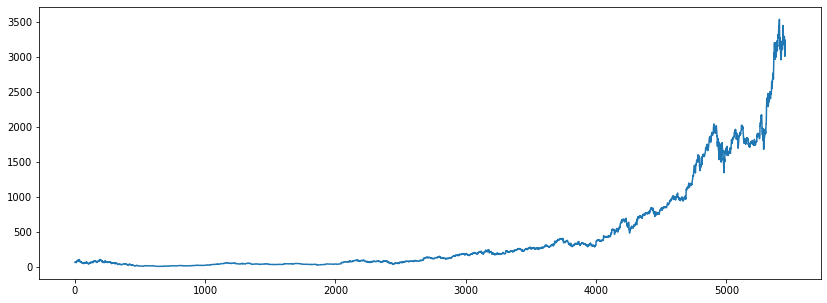

In [49]:
df = data.reset_index()['Close']
plt.figure(figsize = (14,5))
plt.plot(df)
plt.show()

In [50]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5453.000000,5453.000000,5453.000000,5453.000000,5.453000e+03,5453.000000
mean,442.467492,431.974003,437.492917,437.451846,6.835178e+06,437.451846
std,679.813953,663.548260,672.275092,671.974864,5.598460e+06,671.974864
min,6.100000,5.510000,5.910000,5.970000,8.813000e+05,5.970000
25%,43.200001,41.625000,42.380001,42.439999,3.689300e+06,42.439999
50%,122.870003,118.019997,120.559998,120.309998,5.535200e+06,120.309998
75%,435.989990,428.260010,431.549988,431.420013,8.046700e+06,431.420013
max,3552.250000,3486.689941,3547.000000,3531.449951,1.043292e+08,3531.449951


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5453 entries, 1999-03-09 to 2020-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5453 non-null   float64
 1   Low        5453 non-null   float64
 2   Open       5453 non-null   float64
 3   Close      5453 non-null   float64
 4   Volume     5453 non-null   float64
 5   Adj Close  5453 non-null   float64
dtypes: float64(6)
memory usage: 298.2 KB


In [52]:
df.describe()

count    5453.000000
mean      437.451846
std       671.974864
min         5.970000
25%        42.439999
50%       120.309998
75%       431.420013
max      3531.449951
Name: Close, dtype: float64

#**Creating more features**

In [53]:
#closing prices to opening prices (changes) net gain in day
features = pd.DataFrame(index=df.index).sort_index()
features['f01'] = data.reset_index()['Close']/data.reset_index()['Open']-1
features.head()

,f01
0,0.038462
1,0.002742
2,-0.034884
3,-0.005131
4,0.044643


In [54]:
#opening prices compared to previous days closing prices (changes)
array = data.reset_index()['Open']/data.reset_index()['Close'].shift(-1)-1
features['f02'] = array
features.tail()

,f01,f02
5448,0.003043,0.054385
5449,-0.038508,0.051014
5450,-0.018702,0.004373
5451,0.009899,-0.066306
5452,0.023070,NaN


In [55]:
#volume logs
array = data.reset_index()['Volume'].apply(np.log)
features['f03'] = array
features.tail()

,f01,f02,f03
5448,0.003043,0.054385,15.702050
5449,-0.038508,0.051014,15.942122
5450,-0.018702,0.004373,15.797532
5451,0.009899,-0.066306,15.399508
5452,0.023070,NaN,15.276727


In [56]:
#volume difference to previous day
array = data.reset_index()['Volume'].diff()
features['f04'] = array
features.head()

,f01,f02,f03,f04
0,0.038462,-0.087511,16.606185,NaN
1,0.002742,0.013902,16.462933,-2174400.0
2,-0.034884,0.048289,16.603739,2134600.0
3,-0.005131,-0.035538,16.049024,-6919600.0
4,0.044643,-0.006072,15.764388,-2311800.0


In [57]:
#log of 5 days moving average of volume
ma_5 = lambda x : x.rolling(5).mean()
array = data.reset_index()['Volume'].rolling(5,min_periods=1).mean().apply(np.log)
features['f05'] = array
features.head()

,f01,f02,f03,f04,f05
0,0.038462,-0.087511,16.606185,NaN,16.606185
1,0.002742,0.013902,16.462933,-2174400.0,16.537122
2,-0.034884,0.048289,16.603739,2134600.0,16.559824
3,-0.005131,-0.035538,16.049024,-6919600.0,16.454468
4,0.044643,-0.006072,15.764388,-2311800.0,16.349449


In [58]:
#z_score for closing prices
array = (df - df.rolling(200,min_periods=1).mean())/df.rolling(200,min_periods=1).std()
features['f06'] = array
features.tail()

,f01,f02,f03,f04,f05,f06
5448,0.003043,0.054385,15.702050,1008200.0,15.458140,1.107563
5449,-0.038508,0.051014,15.942122,1789900.0,15.632398,0.773956
5450,-0.018702,0.004373,15.797532,-1129000.0,15.675539,0.706880
5451,0.009899,-0.066306,15.399508,-2383000.0,15.693539,0.780917
5452,0.023070,NaN,15.276727,-563199.0,15.653705,1.117131


In [59]:
#signing
array = features['f01'].apply(np.sign)
features['f07'] = array
features.tail()

,f01,f02,f03,f04,f05,f06,f07
5448,0.003043,0.054385,15.702050,1008200.0,15.458140,1.107563,1.0
5449,-0.038508,0.051014,15.942122,1789900.0,15.632398,0.773956,-1.0
5450,-0.018702,0.004373,15.797532,-1129000.0,15.675539,0.706880,-1.0
5451,0.009899,-0.066306,15.399508,-2383000.0,15.693539,0.780917,1.0
5452,0.023070,NaN,15.276727,-563199.0,15.653705,1.117131,1.0


In [60]:
#plus-minus how many days the value has increased or decreased
array = features['f07'].rolling(200,min_periods=1).sum()
features['f08'] = array
features.head()

,f01,f02,f03,f04,f05,f06,f07,f08
0,0.038462,-0.087511,16.606185,NaN,16.606185,NaN,1.0,1.0
1,0.002742,0.013902,16.462933,-2174400.0,16.537122,0.707107,1.0,2.0
2,-0.034884,0.048289,16.603739,2134600.0,16.559824,0.243662,-1.0,1.0
3,-0.005131,-0.035538,16.049024,-6919600.0,16.454468,-0.165545,-1.0,0.0
4,0.044643,-0.006072,15.764388,-2311800.0,16.349449,1.178915,1.0,1.0


#**Creating TA technical indicator features**

In [61]:
pip install --upgrade ta

Requirement already up-to-date: ta in /usr/local/lib/python3.6/dist-packages (0.5.25)


In [62]:
import ta

In [63]:
ta_data = data
ta_data.shape

(5453, 6)

In [64]:
#making sure there are no missing values
ta_data = ta.utils.dropna(ta_data)

In [65]:
ta_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5453 entries, 1999-03-09 to 2020-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5453 non-null   float64
 1   Low        5453 non-null   float64
 2   Open       5453 non-null   float64
 3   Close      5453 non-null   float64
 4   Volume     5453 non-null   float64
 5   Adj Close  5453 non-null   float64
dtypes: float64(6)
memory usage: 298.2 KB


In [66]:
ta_data = ta.add_all_ta_features(ta_data,'Open','High','Low','Close','Volume',fillna=True)
ta_data.head()

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


,High,Low,Open,Close,Volume,Adj Close,volume_adi,volume_obv,volume_cmf,volume_fi,momentum_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-03-09,66.62500,61.71875,62.5625,64.96875,16292000.0,64.96875,5.292306e+06,16292000.0,0.324841,0.000000e+00,50.000000,0.000000,0.000000,-1.384132e+07,1000.000000,64.437500,0.0,64.968750,64.968750,64.968750,0.000000,0.000000,0.0,0.0,64.437500,69.343750,59.531250,15.227934,0.554140,0.0,0.0,7.551708,0.662420,0.000000,0.000000,0.000000,64.968750,64.968750,64.968750,64.968750,0.0,0.0,0.0,0.000000,0.000000,0.000000,-84.727820,1.000000,0.000000,372.483096,-851.483653,-851.483653,0.000000,64.171875,64.171875,64.171875,64.171875,431.91354,421.917072,4.0,4.0,0.0,-1.0,-1.0000,0.0,0.0,100.000000,0.000000,0.000000,66.242038,66.242038,-33.757962,0.0,64.968750,0.0,-85.148365,0.000000,0.000000
1999-03-10,69.46875,67.00000,68.3750,68.56250,14117600.0,68.56250,9.045085e+06,30409600.0,0.297442,5.073512e+07,100.000000,71.041090,71.041090,-1.309146e+07,1055.315055,66.250969,0.0,66.765625,70.359375,63.171875,10.765270,0.750000,0.0,0.0,66.390625,70.078125,62.703125,11.108496,0.794492,0.0,0.0,11.607770,0.883065,0.286681,0.057336,0.229345,66.765625,66.765625,65.521635,65.234954,0.0,0.0,0.0,0.020382,0.000986,0.019396,0.010804,1.918898,66.666667,370.686221,-847.376058,-849.429856,2.053797,65.593750,65.593750,65.593750,65.593750,431.91354,421.917072,8.0,4.0,4.0,-1.0,-1.0000,0.0,0.0,100.000000,100.000000,38.205980,88.306452,77.274245,-11.693548,0.0,66.533679,0.0,5.531506,5.383935,5.531506
1999-03-11,71.37500,65.50000,69.8750,67.43750,16252200.0,67.43750,3.512422e+06,14157400.0,0.075274,4.087529e+07,46.573024,7.342756,39.191923,5.142434e+05,1055.315055,66.896434,0.0,66.989583,69.991464,63.987703,8.962230,0.574606,0.0,0.0,66.961806,71.378472,62.545139,13.191600,0.553852,0.0,0.0,14.414555,0.592233,0.418278,0.129525,0.288753,66.989583,66.989583,65.816383,65.398105,0.0,0.0,0.0,0.031403,0.011250,0.020153,0.024975,2.902402,45.254470,370.462263,-846.864097,-848.574603,1.710506,66.546875,66.546875,66.546875,66.546875,431.91354,421.917072,8.0,4.0,4.0,-1.0,66.6250,0.0,1.0,74.787394,99.306759,36.196319,59.223301,71.257264,-40.776699,0.0,66.927857,0.0,-1.640839,-1.654450,3.799904
1999-03-12,67.68750,64.31250,67.0000,66.65625,9332600.0,66.65625,7.141766e+06,4824800.0,0.127544,3.399438e+07,35.872215,-88.148667,-3.254940,-3.747887e+05,1043.089441,66.783484,0.0,66.906250,69.521933,64.290567,7.818949,0.452211,0.0,0.0,66.776042,70.932292,62.619792,12.448327,0.485589,0.0,0.0,14.432508,0.511327,0.454292,0.194478,0.259814,66.906250,66.906250,65.945593,65.491301,0.0,0.0,0.0,0.036747,0.029286,0.007462,0.038389,3.843755,-25.659472,370.545596,-847.054594,-848.194601,1.140006,66.546875,66.546875,66.546875,66.546875,431.91354,421.917072,8.0,4.0,4.0,65.5,66.6250,1.0,0.0,62.922913,98.259043,42.211055,51.132686,66.220813,-48.867314,0.0,66.803943,0.0,-1.158480,-1.165243,2.597403
1999-03-15,69.50000,65.50000,66.

In [67]:
ta_data.shape

(5453, 78)

In [68]:
#selecting a few features
selected_features = [
                     'volume_adi',
                     'volume_fi',
                     'volatility_bbm',
                     'trend_macd',
                     'trend_vortex_ind_diff',
                     'momentum_rsi',
                     'Close',
                     'trend_cci',
                     'volatility_kcw',
                     'trend_dpo'
                     ]
for i in selected_features:
  array = ta_data.reset_index()[i]
  features[i] = array
features.head()

,f01,f02,f03,f04,f05,f06,f07,f08,volume_adi,volume_fi,volatility_bbm,trend_macd,trend_vortex_ind_diff,momentum_rsi,Close,trend_cci,volatility_kcw,trend_dpo
0,0.038462,-0.087511,16.606185,NaN,16.606185,NaN,1.0,1.0,5.292306e+06,0.000000e+00,64.968750,0.000000,0.000000,100.000000,64.96875,0.000000,15.227934,372.483096
1,0.002742,0.013902,16.462933,-2174400.0,16.537122,0.707107,1.0,2.0,9.045085e+06,5.073512e+07,66.765625,0.286681,0.019396,100.000000,68.56250,66.666667,11.108496,370.686221
2,-0.034884,0.048289,16.603739,2134600.0,16.559824,0.243662,-1.0,1.0,3.512422e+06,4.087529e+07,66.989583,0.418278,0.020153,74.787394,67.43750,45.254470,13.191600,370.462263
3,-0.005131,-0.035538,16.049024,-6919600.0,16.454468,-0.165545,-1.0,0.0,7.141766e+06,3.399438e+07,66.906250,0.454292,0.007462,62.922913,66.65625,-25.659472,12.448327,370.545596
4,0.044643,-0.006072,15.764388,-2311800.0,16.349449,1.178915,1.0,1.0,1.405287e+07,3.195889e+07,67.418750,0.701690,0.015010,77.042704,69.46875,53.373615,12.303868,370.033096


#**Feature Selection**

#normalization


In [69]:
from sklearn.preprocessing import StandardScaler,Normalizer

In [70]:
#normalizing the inputs
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna())
features_scaled.shape

(5451, 18)

In [71]:
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.head()

,f01,f02,f03,f04,f05,f06,f07,f08,volume_adi,volume_fi,volatility_bbm,trend_macd,trend_vortex_ind_diff,momentum_rsi,Close,trend_cci,volatility_kcw,trend_dpo
1,0.068675,0.328644,1.557357,-0.446307,1.776698,0.059109,0.992876,0.006742,-1.323923,1.299385,-0.552209,-0.216073,-0.168548,3.805881,-0.549139,0.415262,0.795762,14.062187
2,-1.269443,1.129351,1.795565,0.438990,1.819147,-0.284824,-1.011630,-0.051873,-1.331631,1.030197,-0.551870,-0.208480,-0.166186,1.741754,-0.550816,0.224048,1.228329,14.053694
3,-0.211312,-0.822557,0.857129,-1.421223,1.622152,-0.588506,-1.011630,-0.110487,-1.326575,0.842339,-0.551996,-0.206402,-0.205779,0.770423,-0.551980,-0.409225,1.073984,14.056854
4,1.558815,-0.136446,0.375597,-0.474536,1.425787,0.409248,0.992876,-0.051873,-1.316947,0.786767,-0.551220,-0.192127,-0.182230,1.926394,-0.547788,0.296553,1.043987,14.037419
5,-1.356091,1.426933,0.495037,0.105951,1.146003,-0.667617,-1.011630,-0.110487,-1.324518,0.586820,-0.551350,-0.193199,-0.170411,0.210664,-0.551608,0.129586,1.006903,14.040659


In [72]:
input_df = df
output_df = df['Close'] 
print(output_df.tail())


5447    4.062557
5448    4.134441
5449    3.873825
5450    3.826623
5451    3.892097
Name: Close, dtype: float64


In [73]:
corr = input_df.corrwith(output_df)
corr

f01                     -0.014681
f02                     -0.007903
f03                     -0.306999
f04                      0.000543
f05                     -0.356253
f06                      0.274999
f07                     -0.002329
f08                     -0.030896
volume_adi               0.669658
volume_fi                0.098408
volatility_bbm           0.998462
trend_macd               0.488995
trend_vortex_ind_diff    0.125400
momentum_rsi             0.159044
Close                    1.000000
trend_cci                0.116792
volatility_kcw          -0.338337
trend_dpo               -0.076758
dtype: float64

In [74]:
selected_columns = corr[corr>0.1].index.to_list()
corr = input_df[selected_columns].corrwith(output_df)
corr

f06                      0.274999
volume_adi               0.669658
volatility_bbm           0.998462
trend_macd               0.488995
trend_vortex_ind_diff    0.125400
momentum_rsi             0.159044
Close                    1.000000
trend_cci                0.116792
dtype: float64

In [75]:
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance

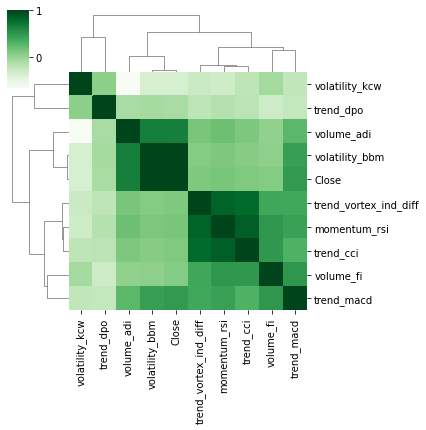

In [76]:
corr_matrix = input_df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)
linkage = hierarchy.linkage(distance.pdist(correlations_array),method='average')
g=sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [77]:
#ignore the close input
label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength")
print(corr[corr>0.1].sort_values(ascending=False))

Correlation Strength
Close                    1.000000
volatility_bbm           0.998462
volume_adi               0.669658
trend_macd               0.488995
f06                      0.274999
momentum_rsi             0.159044
trend_vortex_ind_diff    0.125400
trend_cci                0.116792
dtype: float64


In [78]:
input_df.head()

,f01,f02,f03,f04,f05,f06,f07,f08,volume_adi,volume_fi,volatility_bbm,trend_macd,trend_vortex_ind_diff,momentum_rsi,Close,trend_cci,volatility_kcw,trend_dpo
1,0.068675,0.328644,1.557357,-0.446307,1.776698,0.059109,0.992876,0.006742,-1.323923,1.299385,-0.552209,-0.216073,-0.168548,3.805881,-0.549139,0.415262,0.795762,14.062187
2,-1.269443,1.129351,1.795565,0.438990,1.819147,-0.284824,-1.011630,-0.051873,-1.331631,1.030197,-0.551870,-0.208480,-0.166186,1.741754,-0.550816,0.224048,1.228329,14.053694
3,-0.211312,-0.822557,0.857129,-1.421223,1.622152,-0.588506,-1.011630,-0.110487,-1.326575,0.842339,-0.551996,-0.206402,-0.205779,0.770423,-0.551980,-0.409225,1.073984,14.056854
4,1.558815,-0.136446,0.375597,-0.474536,1.425787,0.409248,0.992876,-0.051873,-1.316947,0.786767,-0.551220,-0.192127,-0.182230,1.926394,-0.547788,0.296553,1.043987,14.037419
5,-1.356091,1.426933,0.495037,0.105951,1.146003,-0.667617,-1.011630,-0.110487,-1.324518,0.586820,-0.551350,-0.193199,-0.170411,0.210664,-0.551608,0.129586,1.006903,14.040659


# **Backtesting and prediction loop**

In [79]:
series = input_df
output = output_df
X = series.values
n_train = 504
n_records = len(X)
acc_results = output[504:len(X)]


def model_train(model):
  prediction = np.empty(shape=(0,0))
  for i in range(n_train, n_records):
    train_x,test_x=X[(i-n_train)+0:i],X[i:i+1]
    train_y,test_y=output[(i-n_train)+0:i],output[i:i+1]
    model.fit(train_x,train_y)
    pred_value = model.predict(test_x)
    prediction = np.append(prediction,pred_value)
  return prediction
from sklearn.metrics import mean_squared_error
def rmse_value(acc_results,predictions):
  mse = mean_squared_error(acc_results,predictions)
  rmse = np.sqrt(mse)
  return rmse
  

###**defining models**

In [80]:
from sklearn.tree import DecisionTreeRegressor
regression_tree_model = DecisionTreeRegressor(criterion='friedman_mse',
                                              max_depth=10,
                                              min_samples_leaf=50)

In [81]:
predictions = model_train(regression_tree_model)
predictions

array([-0.62281335, -0.62294387, -0.6230616 , ...,  3.47554522,
        3.47411889,  3.47183466])

In [82]:
tree_rmse = rmse_value(acc_results,predictions)
tree_rmse

0.10816037866993031

getting the best parameters for the decision tree

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipe_tree = make_pipeline(regression_tree_model)
depths = np.arange(1, 21)
num_leafs = [1, 5, 10, 20, 50, 100]
param_grid = [{'decisiontreeregressor__max_depth':depths,
              'decisiontreeregressor__min_samples_leaf':num_leafs}]
gs = GridSearchCV(estimator=pipe_tree, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)

In [ ]:
temp_x = X[4947:5451]
temp_y = output[4947:5451]
gs.fit(temp_x,temp_y)

In [94]:
print(gs.best_params_)
print(-gs.best_score_)

{'decisiontreeregressor__max_depth': 14, 'decisiontreeregressor__min_samples_leaf': 10}
0.023521821914327685


running our main loop function over the values with our updated parameters

In [96]:
regression_tree_model = DecisionTreeRegressor(criterion='friedman_mse',
                                              max_depth=14,
                                              min_samples_leaf=10)
predictions = model_train(regression_tree_model)
tree_rmse = rmse_value(acc_results,predictions)
tree_rmse

0.034721461347762834